# Logistic Regression as a Single Neuran of a Neural Network

Welcome to your first programming assignment! You will build a logistic regression classifier to recognize  cats. This assignment will step you through how to do this with a Neural Network mindset where logistic regression represents a single nueron. 

**Instructions:**
- Do not use loops (for/while) in your code, unless the instructions explicitly ask you to do so.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

## 1 -  Loading Packages ##
First, let's run the cell below to import all the packages that you will need during this assignment. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import glob
from sklearn.model_selection import train_test_split

%matplotlib inline

## 2 - Utility functions to convert images into datasets ##
The following functions are used to convert the cats and dogs images in the dataset folder into the numpy array format with labels. 

In [7]:
def convert_image_to_data(image, WIDTH, HEIGHT):
    image_resized = Image.open(image).resize((WIDTH, HEIGHT))
    image_array = np.array(image_resized).T
    return image_array

In [8]:
def create_train_test_data(num_pix,test_size=0.2):
    cat_files = glob.glob("datasets/cat*")
    dog_files = glob.glob("datasets/dog*")

    # Restrict cat and dog files here for testing
    cat_list = [convert_image_to_data(i, num_pix, num_pix) for i in cat_files]
    dog_list = [convert_image_to_data(i, num_pix, num_pix) for i in dog_files]

    y_cat = np.zeros(len(cat_list))
    y_dog = np.ones(len(dog_list))

    X = np.concatenate([cat_list, dog_list])
    X = np.concatenate([cat_list, dog_list])
    y = np.concatenate([y_cat, y_dog])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
    return X_train, X_test, y_train, y_test


In [9]:
def load_dataset(database_path):
    # open dataset 
    dataset_db = h5py.File(database_path, "r")
    datasets = {}
    for dataset in ["train", "dev", "test"]:
        datasets[dataset] = {'X' : np.array(dataset_db[dataset + "_img"][:]),  # dataset features
                              'Y' : np.array(dataset_db[dataset + "_labels"][:])}
    return datasets

### 2.1 - Load data set ###
Use the utility functions provided above to load the train_set_x,train_set_y, test_set_x, test_set_y.
Set the `num_pix` to 64 and keep the `test_size` as the default value.

In [10]:
# set the num_pix to 64
num_pix = 64
# load the train_set_x_orig, test_set_x_orig, train_set_y, test_set_y
#train_set_x, test_set_x, train_set_y, test_set_y = create_train_test_data(num_pix, test_size = 0.2)
#comment the above line and uncomment the below line in order to load the car dataset
dataset = load_dataset('car_dataset.hdf5')
train_set_x = dataset["train"]["X"]
test_set_x = dataset["test"]["X"]
train_set_y = dataset["train"]["Y"]
test_set_y = dataset["test"]["Y"]

#### 2.1.1 - Print the shapes ###
Print the shape of the following variables
- Number of training examples: m_train
- Number of testing examples: m_test
- Height/Width of each image: num_px
- train_set_x shape
- train_set_y shape
- test_set_x shape
- test_set_y shape

In [11]:
# your code here

m_train = train_set_x.shape[0]
m_test = test_set_x.shape[0]

print("Number of training examples:",str(m_train))
print("Number of testing examples:",str(m_test))
print("Height/Width of each image:",str(num_pix))
print("train_set_x shape:",str(train_set_x.shape))
print("train_set_y shape:",str(train_set_y.shape))
print("test_set_x shape:",str(test_set_x.shape))
print("test_set_y shape:",str(test_set_y.shape))



Number of training examples: 517
Number of testing examples: 173
Height/Width of each image: 64
train_set_x shape: (517, 64, 64, 3)
train_set_y shape: (517,)
test_set_x shape: (173, 64, 64, 3)
test_set_y shape: (173,)


#### 2.1.2 - Fixing ill-shape vectors ####
It is possible that the train_set_y and test_set_y have an ill-shape. Fix these shapes so the train_set_y and test_set_y are represented as a matrix with size (1, number of examples)

In [12]:
# your code here <begin>
Y_train = train_set_y.reshape(1,m_train)
Y_test = test_set_y.reshape(1,m_test)
# your code here <end>

print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_y shape: (517,)
test_set_y shape: (173,)


### 2.2 - Flatten the data
Reshape the training and test data sets so that each image is flattened into single vectors of shape (num_px  ∗ num_px  ∗ 3, 1). Check the shapes for train_set_x_flatten and test_set_x_flatten.

In [13]:
# your code here

train_set_x_flatten = train_set_x.reshape(train_set_x.shape[0],-1).T
test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0],-1).T
print(train_set_x_flatten.shape)

(12288, 517)


### 2.3 - Standardize the data
Divide every row of the dataset by 255 

In [14]:
# your code here

X_train = np.divide(train_set_x_flatten,255)
X_test = np.divide(test_set_x_flatten,255)

## 3 - Implementing the Helper Functions ## 

### 3.1 - Sigmoid function
Implement `sigmoid()`. 

In [15]:
# your code here

def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

### 3.2 - Implement initialize_with_zeros
Write a function that initializes initialize w as a vector of zeros and set `b` to zero. 

In [12]:
# your code here

def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    print(w.shape)
   
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

### 3.3 - Forward propagation

Implement forward propagation to calculate $A$ and cost.

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$


In [56]:
# your code here

def forward_propagate(w,b,X,Y):
    m = X.shape[1]
    Z = np.dot(w.T,X)+b
    A = sigmoid(Z)     # compute activation
    cost = (-1/m) * (np.sum(Y*np.log(A)+ (1-Y)*np.log(1-A)))
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return A, cost

### 3.4 - Backward propagation

Implement backward propagation to compute gradients $dw$ and $db$
Here are the two formulas you will be using: 

$$ dw = \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ db = \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [57]:
# your code here

def backward_propagate(A,X,Y):
    m = X.shape[1]
    dz = A-Y
    dw = (1/m)*np.dot(X,dz.T)
    db = (1/m)*np.sum(dz)
    #assert(dw.shape == w.shape)
    assert(db.dtype == float)
    grads = {"dw": dw,
             "db": db}
    
    return grads

### 3.5 - Optimization
- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. 

In [58]:
# your code here

def optimize(w, b, X, Y, num_iterations, learning_rate):
    costs = []
    
    for i in range(num_iterations):
          
        # Cost and gradient calculation (≈ 1-4 lines of code)
        A, cost = forward_propagate(w,b,X,Y)
        grads = backward_propagate(A,X,Y)
        # Retrieve derivatives from grads dictionary
        dw = grads['dw'] 
        db = grads['db']         
        # update rule (≈ 2 lines of code)
        w = w - learning_rate * dw
        b = b - learning_rate*db
        
        # Record the costs every 100 iterations
        if i % 100 == 0:
            costs.append(cost)
            #print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

### 3.6 - Prediction

Implement the `predict()` function. There is two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [59]:
# your code here

def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    Z = np.dot(w.T,X) + b
    A = sigmoid(Z)
    A[A>0.5] = 1
    A[A<=0.5] = 0
    Y_prediction = A
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

## 4 - Regression Model ##
Implement the model function. Use the following notation:
    - Y_prediction for your predictions on the test set
    - Y_prediction_train for your predictions on the train set
    - w, costs, grads for the outputs of optimize()

In [60]:
# your code here

def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate):
        
    # initialize parameters with zeros (≈ 1 line of code)
    n = X_train.shape[0]
    w, b = initialize_with_zeros(n)

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters['w']
    b = parameters['b']
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    
    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

## 5. Run the regression model function to train your model.
### 5.1 - Setting parameters (part 1)
Set the `num_iterations` to 5000 and `learning_rate` to 0.0005

In [61]:
# your code here

num_iterations = 5000
learning_rate = 0.0005
print("Running the model")
d = model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate)

Running the model
(12288, 1)
train accuracy: 92.06963249516441 %
test accuracy: 87.28323699421965 %


**Expected Output**: 

<table style="width:40%"> 
    
    <tr>
        <td> **Train Accuracy**  </td> 
        <td> 91.25 % </td>
    </tr>

    <tr>
        <td>**Test Accuracy** </td> 
        <td> 60.0 % </td>
    </tr>
</table> 




Let's also plot the cost function and the gradients.

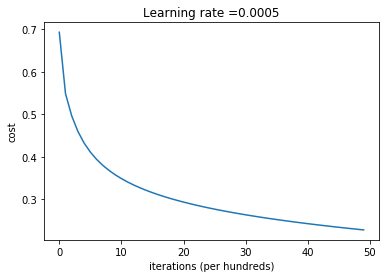

In [62]:
# Plot learning curve (with costs) for part 1

costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

### 5.1 - Setting parameters (part 2)
Set the `num_iterations` to 2000 and `learning_rate` to 0.005 and run the model again. Plot the cost function.

In [63]:
# your code here
num_iterations = 2000
learning_rate = 0.005
print("Running the model")
d = model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate)

Running the model
(12288, 1)
train accuracy: 97.48549323017409 %
test accuracy: 89.59537572254335 %


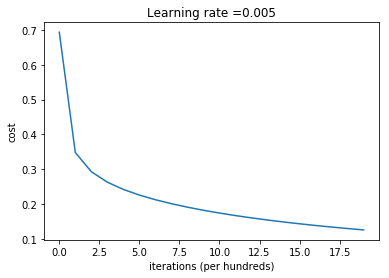

In [64]:
# Plot learning curve (with costs) for part 2

costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

### 5.3 - Analysis
Compare the cost function plots of part_1 and part_2. Write your observation below.

#### Write Your observation here


In the cat dataset for part 1 where the no. of iterations is 5000 and the learning rate is 0.0005 we observe a steep decrease in the begining and then a gradual decrease in the cost as the no of iterartions increases. For part 2 of the cat dataset wherein the number of iterations is 2000 and the leaning rate is 0.005, we observe a  steep increase in cost with respect to the number of iterations at the begining and then a gradual decrese in the cost. This is due to the high learning rate. In the car dataset for part 1 the plot decreases steeply with respect to the no of iterations in the begining and then the rate of decrease becomes gradual. In the car dataset for part 2 there is a steep decrease and then a gradual decrease.